In [1]:
%matplotlib inline


# Imputing missing values before building an estimator


Missing values can be replaced by the mean, the median or the most frequent
value using the basic :class:`sklearn.impute.SimpleImputer`.
The median is a more robust estimator for data with high magnitude variables
which could dominate results (otherwise known as a 'long tail').

Another option is the :class:`sklearn.impute.IterativeImputer`. This uses
round-robin linear regression, treating every variable as an output in
turn. The version implemented assumes Gaussian (output) variables. If your
features are obviously non-Normal, consider transforming them to look more
Normal so as to potentially improve performance.

In addition of using an imputing method, we can also keep an indication of the
missing information using :func:`sklearn.impute.MissingIndicator` which might
carry some information.



C:\Users\xrustle\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\xrustle\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\xrustle\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\xrustle\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\xrustle\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\xrustle\Anaconda3\lib\site-packages\

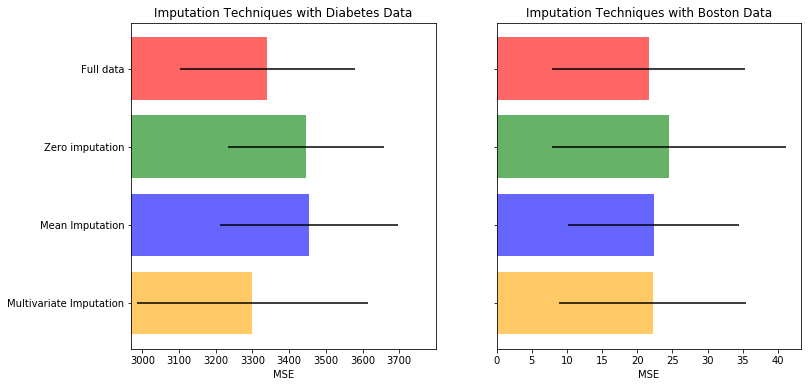

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer, MissingIndicator, IterativeImputer
from sklearn.model_selection import cross_val_score

rng = np.random.RandomState(0)

N_SPLITS = 5
REGRESSOR = RandomForestRegressor(random_state=0, n_estimators=100)


def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(
        make_union(imputer, MissingIndicator(missing_values=0)),
        REGRESSOR)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring='neg_mean_squared_error',
                                    cv=N_SPLITS)
    return impute_scores


def get_results(dataset):
    X_full, y_full = dataset.data, dataset.target
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]

    # Estimate the score on the entire dataset, with no missing values
    full_scores = cross_val_score(REGRESSOR, X_full, y_full,
                                  scoring='neg_mean_squared_error',
                                  cv=N_SPLITS)

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(np.floor(n_samples * missing_rate))
    missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples,
                                          dtype=np.bool),
                                 np.ones(n_missing_samples,
                                         dtype=np.bool)))
    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[np.where(missing_samples)[0], missing_features] = 0
    y_missing = y_full.copy()

    # Estimate the score after replacing missing values by 0
    imputer = SimpleImputer(missing_values=0,
                            strategy='constant',
                            fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after imputation (mean strategy) of the missing values
    imputer = SimpleImputer(missing_values=0, strategy="mean")
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after iterative imputation of the missing values
    
    imputer = IterativeImputer(missing_values=0,
                               random_state=0,
                               n_nearest_features=5)
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing)
    
    return ((full_scores.mean(), full_scores.std()),
            (zero_impute_scores.mean(), zero_impute_scores.std()),
            (mean_impute_scores.mean(), mean_impute_scores.std()),
            (iterative_impute_scores.mean(), iterative_impute_scores.std()))


results_diabetes = np.array(get_results(load_diabetes()))
mses_diabetes = results_diabetes[:, 0] * -1
stds_diabetes = results_diabetes[:, 1]

results_boston = np.array(get_results(load_boston()))
mses_boston = results_boston[:, 0] * -1
stds_boston = results_boston[:, 1]

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

x_labels = ['Full data',
            'Zero imputation',
            'Mean Imputation',
            'Multivariate Imputation']
colors = ['r', 'g', 'b', 'orange']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_diabetes[j], xerr=stds_diabetes[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques with Diabetes Data')
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9,
             right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot boston results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(j, mses_boston[j], xerr=stds_boston[j],
             color=colors[j], alpha=0.6, align='center')

ax2.set_title('Imputation Techniques with Boston Data')
ax2.set_yticks(xval)
ax2.set_xlabel('MSE')
ax2.invert_yaxis()
ax2.set_yticklabels([''] * n_bars)

plt.show()